In [178]:
############********** Project1 Task2 Training File **********############


import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.datasets import make_classification
from sklearn_pandas import CategoricalImputer
#from feature_engine.imputation import CategoricalImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
import datetime as dt

from datetime import date
import holidays

pd.set_option("display.max_columns", None)


In [287]:
###--- Connecting to the server to access the database ---###

conn = pyodbc.connect('Driver={SQL Server};'
'Server=HCV171DTMBPDA01\DTMBSQL16PRD.NGDS.state.mi.us,1910;'
'Database=DTMB_CentralProcurement;'
'Trusted_Connection=yes;')

cursor = conn.cursor()

In [288]:
###--- Retrieving tables from the database using queries ---###

query_1 = "SELECT * FROM tblProjects WHERE ProjectType = 'RFP' Or ProjectType\
= 'C-RFP' Or ProjectType = 'CN' Or ProjectType = 'DS' Or ProjectType = 'CO-OP'Or ProjectType = 'ITN'Or ProjectType = 'CPC' Or ProjectType = 'RFS'"
query_2 = "SELECT * FROM tblContractCategories"


df_projects = pd.read_sql_query(query_1, conn)
df_projects = df_projects[df_projects['CategoryID'].notna()]
df_projects = df_projects.astype({'CategoryID': 'int64'})

df_level = pd.read_sql_query(query_2, conn)
df_level = df_level[['LevelCalc', 'CategoryID']]

df = df_projects.join(df_level.set_index('CategoryID'), on='CategoryID')
df = df[(df["ProjectStage"] == 'Complete')]
df.shape

(4189, 35)

In [338]:
df

,ID,SharePointID,ProjectColor,ProjectName,ProjectType,CreateDate,CreatedBy,PlanStartDate,PlanFinishDate,StatusDate,ProjectDescription,DollarAmount,Status,WorkPerformedFor,RefrenceNumber,ProjectStage,CancelationReason,BuyerName,Hours,SensitivityIndicator,Division,SourcingCategory,ActualFinishDate,Unit,SLA,Planned,SolicitationStatus,LastUpdatedBy,LastUpdateDate,LastUpdatedField,CategoryID,FedReview,ITComponent,SolicitationNum,LevelCalc
2,3339,3339,Green,"Segal Advisors, Inc",CN,2017-07-17,keilenn,2017-07-17,2017-10-12,2017-07-17,The State of Michigan is requesting an amendme...,48800.00,Received Chapter 5 Approval on 07/17/2017. In...,071,C20170714-131440,Complete,0.0,JY1,0.0,False,PROF,"Consulting, Financial",2017-07-24,NaN,63,Yes,None,testM,2019-03-06 16:23:21,", Project Stage",50,False,False,None,3
3,3570,3570,Green,2018 Heavy Truck Annual Pricing,RFP,2017-07-17,Gibrilm,2017-08-16,2017-11-17,2017-11-06,This request is to obtain 2018 Heavy Truck Ann...,0.00,Complete,000,None,Complete,0.0,YMD,120.0,False,COMM,"Motor Vehicles, Heavy Trucks",2017-11-02,NaN,138,Yes,New-Bid,testM,2019-03-06 16:25:28,", Project Stage, Dollar Amount",185,False,False,None,2
4,3571,3571,Green,2018 Vehicle Model Annual Pricing,RFP,2017-07-17,Gibrilm,2017-08-14,2017-11-17,2017-11-06,This request is for 2018 Vehicle Model Annual ...,NaN,Complete.,000,None,Complete,0.0,YMD,120.0,False,COMM,"Motor Vehicles, General",2017-11-06,NaN,138,None,New-Bid,None,NaT,None,184,False,False,None,3
6,3574,3574,Green,Aerial Towers and Accessories,RFP,2017-07-17,Gibrilm,2017-03-02,2017-09-17,2017-06-12,Purchase and rentals of Aerial Towers and acce...,5000000.00,Multi award. Both contracts executed.,591,C20170209-090304,Complete,0.0,YMD,120.0,False,COMM,"Motor Vehicle, Accessories",2017-07-25,NaN,138,None,None,None,NaT,None,301,False,False,None,2
11,3580,3580,Green,"Cholestech, Afinion and iFOBT Equip. and Test...",RFP,2017-07-17,Gibrilm,2017-05-18,2017-12-03,2018-01-29,DHHS Cancer Prevention Section requests to est...,182413.44,New contract has been executed. Request compl...,431,C20170512-141419,Complete,0.0,SR4,120.0,False,COMM,Lab Equipment & Supplies,2018-02-01,NaN,138,None,Re-Bid,None,NaT,None,143,False,False,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7499,13131,13131,Green,071B4300148 - Agilent - add funds and equipment,CN,2022-05-02,riggs,2022-05-02,2022-07-12,2022-05-02,The purpose of this amendment is for the Michi...,11650.66,"Buyer Assigned, complete 5/4/2022",491,GR 22*1547,Complete,0.0,KMC,7.0,False,COMM,Lab Equipment & Supplies,2022-05-04,NaN,50,No,N/A,McFarlandK,2022-05-04 08:03:49,", Actual Finish Date, Project Stage",143,False,False,None,4
7508,13140,13140,Green,071B7700095 - Morrison Industrial - Pricing up...,CN,2022-05-04,riggs,2022-04-13,2022-04-21,2022-05-05,071B7700095 - Morrison Industrial - Pricing up...,0.00,Buyer Assigned,000,GR 22*1622,Complete,0.0,YMD,7.0,False,COMM,Construction Equipment,2022-04-21,NaN,50,No,N/A,dufoury,2022-05-05 07:59:31,", Status Date, Project Stage",47,False,False,None,2
7509,13141,13141,Green,200000000470 - Resource Recycling - Administra...,CN,2022-05-04,riggs,2022-03-03,2022-04-15,2022-05-04,200000000470 - Resource Recycling - Adnministr...,0.00,Buyer Assigned,171,GR 22*1627,Complete,0.0,YMD,7.0,False,COMM,Records Management,2022-04-15,NaN,50,No,N/A,dufoury,2022-05-05 07:54:28,", Project Stage",226,False,False,None,2
7510,13142,13142,Green,190000000369 - Goodyear - pricing updates,CN,2022-05-04,riggs,2022-03-01,2022-04-01,2022-05-04,190000000369 - Goodyear - pricing updates,0.00,Buyer Assigned,000,GR 22*1626,Complete,0.0,YMD,7.0,False,COMM,"Motor Vehicle, Tires",2022-04-01,NaN,50,No,N/A,dufoury,2022-05-05 07:52:34,", Actual Finish Date, Project Stage",182,False,False,None,2


# Data Preparation and Cleansing 

In [289]:
###--- Data pre-processing and cleaning for training model---###

def prepare_df2(df):
    
    #Calculating the duration
    df = df.reset_index()
    df = df.dropna(subset=['PlanFinishDate'])
    mi_holidays = holidays.UnitedStates(state='MI')
    start = df['PlanStartDate'].astype(str)
    end = df['ActualFinishDate'].astype(str)
    bus = []
    holi = []
    dur = []
    start_list = start.tolist()
    end_list = end.tolist()
    for i in range(len(start_list)):
        holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
        bus.append(np.busday_count(start_list[i], end_list[i]))

    zip_object = zip(bus, holi)
    for list1_i, list2_i in zip_object:
        dur.append(list1_i-list2_i)
    df['dur'] = dur
    variables_to_remove = ['index','SharePointID', 'ID', 'ProjectName', 'CreateDate', 'PlanStartDate',
             'PlanFinishDate', 'StatusDate', 'ProjectDescription', 'Status', 'StatusDate', 'ProjectDescription',
             'Status', 'RefrenceNumber', 'ProjectStage', 'CancelationReason', 'ActualFinishDate', 'Unit',
             'SolicitationStatus', 'LastUpdatedBy', 'LastUpdateDate', 'LastUpdatedField', 'SolicitationNum',
             'SensitivityIndicator', 'SourcingCategory', 'DollarAmount'] # Business requested removal of the following features

    df = df.drop(variables_to_remove, axis = 1)
    df = df.rename(columns={"dur": "Duration"})
    df = df[df["Duration"]>0]
    # handling NaN values
    imputer = CategoricalImputer()
    data = np.array(df['Planned'], dtype=object)
    data2 = np.array(df['CreatedBy'], dtype=object)
    data3 = np.array(df['BuyerName'], dtype=object)

    df['Planned'] = imputer.fit_transform(data)
    df['CreatedBy'] = imputer.fit_transform(data2)
    df['BuyerName'] = imputer.fit_transform(data3)
    df = df.dropna()
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    return df

def met_sla(df):
    
    if df['Duration'] <= df['SLA']:
        val = 1
    elif df['Duration'] > df['SLA']:
        val = 0
    return val

model2_df = prepare_df2(df)
model2_df['Met_SLA'] = model2_df.apply(met_sla, axis=1)
model2_df.head()

,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Duration,Met_SLA
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,5,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,54,1
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,58,1
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,101,1
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,172,0


# Creating Labels for Different durations

In [290]:
#putting duration ranges into categories

duration = []
for item in model2_df['Duration'].to_list():
    if abs(int(item)) >=0 and abs(int(item)) < 50:
        duration.append(1)
    elif abs(int(item)) >=50 and abs(int(item)) < 100:
        duration.append(2)
    elif abs(int(item)) >=100 and abs(int(item)) < 150:
        duration.append(3)
    elif abs(int(item)) >=150 and abs(int(item)) < 200:
        duration.append(4)
    elif abs(int(item)) >=200 and abs(int(item)) < 250:
        duration.append(5)
    elif abs(int(item)) >=250 and abs(int(item)) < 300:
        duration.append(6)
    elif abs(int(item)) >=300 and abs(int(item)) < 350:
        duration.append(7)
    elif abs(int(item)) >=350 and abs(int(item)) < 400:
        duration.append(8)
    elif abs(int(item)) >=400:
        duration.append(9)

#creating duration category column
model2_df['DurationCat'] = duration
model2_df = model2_df.drop(['Duration'], axis = 1)

print(model2_df.shape)
model2_df.head()


(3373, 15)


,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Met_SLA,DurationCat
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,1,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,1,2
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,1,2
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,1,3
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,0,4


In [291]:
from sklearn.impute import SimpleImputer
#X = model2_df.iloc[:,3 ].values
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#imputer = imputer.fit(X[:, 1:3])
#X[:, 3] = imputer.transform(X[:, 3])

#model2_df['DollarAmount'] = model2_df['DollarAmount'].fillna((model2_df['DollarAmount'].mean()))

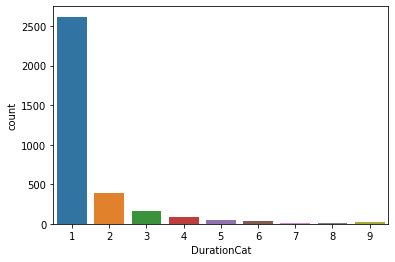

In [292]:
sns.countplot(model2_df['DurationCat'],label="Count")

In [293]:
model2_df.columns

Index(['ProjectColor', 'ProjectType', 'CreatedBy', 'WorkPerformedFor',
       'BuyerName', 'Hours', 'Division', 'SLA', 'Planned', 'CategoryID',
       'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA', 'DurationCat'],
      dtype='object')

# Feature Selection 

In [294]:
X = model2_df[['ProjectColor', 'ProjectType', 'CreatedBy',  'WorkPerformedFor', 'BuyerName', 'Hours', 'Division', 'SLA', 'Planned',
         'CategoryID', 'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA']]
y = model2_df['DurationCat']

In [295]:
from matplotlib import pyplot as plt

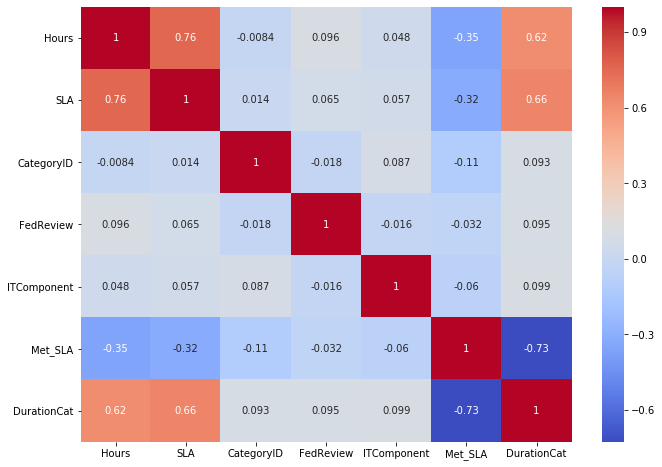

In [296]:
corr = model2_df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="coolwarm",annot=True)
plt.show()

In [297]:
###--- Functions that prepares data for model--> turns data entries to a form the model can read ---###

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= 569)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X = model2_df.iloc[:, :-1]
y = model2_df.iloc[:,-1]
    # format all fields as string
X = X.astype(str)
np.set_printoptions(threshold=sys.maxsize)
num = 0
feature_name = []
for i in X:
    print("Feature number: "+str(num)+" "+str(i))
    num+=1
    feature_name.append(i)

Feature number: 0 ProjectColor
Feature number: 1 ProjectType
Feature number: 2 CreatedBy
Feature number: 3 WorkPerformedFor
Feature number: 4 BuyerName
Feature number: 5 Hours
Feature number: 6 Division
Feature number: 7 SLA
Feature number: 8 Planned
Feature number: 9 CategoryID
Feature number: 10 FedReview
Feature number: 11 ITComponent
Feature number: 12 LevelCalc
Feature number: 13 Met_SLA


In [325]:
###--- Running algorithm that selects the best features ---###


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection



In [326]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train_enc,y_train_enc,random_state=42)
for i in mi_score:
    print(round(i,2))

0.0
0.14
0.04
0.01
0.03
0.15
0.04
0.16
0.03
0.03
0.01
0.0
0.02
0.33


In [327]:
df_featur_selection = pd.DataFrame()
df_featur_selection['Feature_Name'] = feature_name
df_featur_selection['mi_scores'] = mi_score
df_featur_selection = df_featur_selection.sort_values(by ='mi_scores',ascending=False )

df_featur_selection

,Feature_Name,mi_scores
13,Met_SLA,0.331606
7,SLA,0.156911
5,Hours,0.148432
1,ProjectType,0.144667
2,CreatedBy,0.044927
6,Division,0.041554
9,CategoryID,0.034060
4,BuyerName,0.033410
8,Planned,0.027905
12,LevelCalc,0.016798


In [328]:
remove_lst = df_featur_selection[df_featur_selection['mi_scores']<0.001].index
remove_lst

Int64Index([0, 11], dtype='int64')

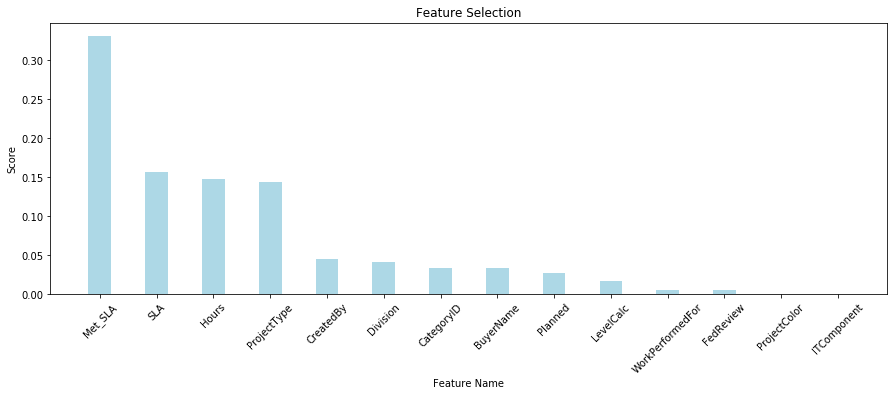

In [329]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(df_featur_selection['Feature_Name'], df_featur_selection['mi_scores'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Feature Name")
plt.ylabel("Score")
plt.title("Feature Selection")
plt.show()

# Bias handling and Model Selection 

In [330]:
X_train_enc = np.delete(X_train_enc, np.s_[remove_lst], 1)
X_test_enc = np.delete(X_test_enc, np.s_[remove_lst], 1)

In [331]:
oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)

C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1766)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

In [172]:
def ave_score(model):
    scores=[]
    for i in range(10):
        model.fit(X_s, y_s)
        score = model.score(X_test_enc, y_test_enc)
        scores.append(score)
    return sum(scores)/len(scores)
    

In [66]:
#ave_score(RandomForestClassifier(n_estimators=1000))

In [336]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
result_df = pd.DataFrame()

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
random_state=42
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,random_state=random_state),
    SVC(gamma=2, C=1,random_state=random_state),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=7, n_estimators=1000, max_features=1,random_state=random_state),
    MLPClassifier(alpha=1, max_iter=1000,random_state=random_state),
    AdaBoostClassifier(random_state=random_state),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

name_lst= []
result_model=[]
for name, clf in zip(names, classifiers):
            clf.fit(X_s, y_s)
            score = clf.score(X_test_enc, y_test_enc)
            #score= ave_score(clf)
            name_lst.append(name)
            result_model.append(score)
            print(name, score)
        
       
result_df['model Name'] = name_lst
result_df['score'] = result_model

result_df

Nearest Neighbors 0.618491921005386
Linear SVM 0.8509874326750448
RBF SVM 0.4452423698384201
Decision Tree 0.8707360861759426
Random Forest 0.8707360861759426
Neural Net 0.8276481149012568
AdaBoost 0.059245960502693
Naive Bayes 0.7971274685816876
QDA 0.7639138240574507


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:903: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:903: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:906: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


,model Name,score
0,Nearest Neighbors,0.618492
1,Linear SVM,0.850987
2,RBF SVM,0.445242
3,Decision Tree,0.870736
4,Random Forest,0.870736
5,Neural Net,0.827648
6,AdaBoost,0.059246
7,Naive Bayes,0.797127
8,QDA,0.763914


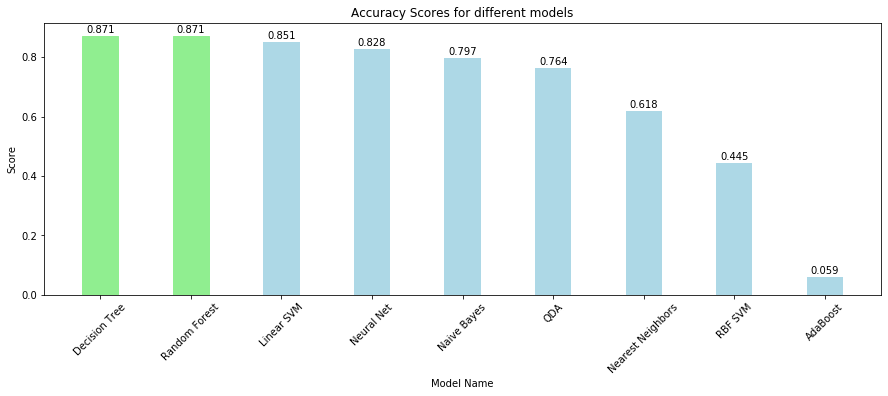

In [337]:
result_df = result_df.sort_values(by= 'score',ascending=False )

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(result_df['model Name'], result_df['score'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Model Name")
plt.ylabel("Score")
plt.title("Accuracy Scores for different models")

for x,y in zip(result_df['model Name'], result_df['score']):

    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,3), 
                 ha='center') 
bar[0].set_color('lightgreen')
bar[1].set_color('lightgreen')
#plt.text(4.5,.85,'Random Forest Classifier'+str(max(result_df['score'])))
plt.show()

In [136]:
max_depth_dt = []
scores_dt = []
for i in range(1,30):
    model = DecisionTreeClassifier(max_depth=i)
    model = model.fit(X_s, y_s)
    score = model.score(X_test_enc, y_test_enc)
    max_depth_dt.append(i)
    scores_dt.append(score)


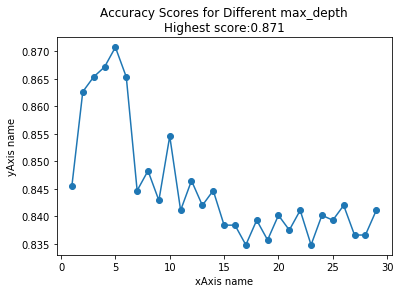

In [228]:
plt.plot(max_depth_dt,scores_dt,marker='o')
plt.title('Accuracy Scores for Different max_depth'+'\n' 'Highest score:' +str(round(max(scores_dt),3)))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

In [335]:
model = DecisionTreeClassifier(max_depth=5)
model = model.fit(X_s, y_s)
    # evaluate the model
score = model.score(X_test_enc, y_test_enc)
   
print('Accuracy: %.3f' % (score))

Accuracy: 0.871


In [140]:
max_depth_rf = []
scores_rf = []
for i in range(1,20):
    model = RandomForestClassifier(max_depth=i, n_estimators=1000, max_features=1,random_state=42)
    model = model.fit(X_s, y_s)
    score = model.score(X_test_enc, y_test_enc)
    max_depth_rf.append(i)
    scores_rf.append(score)

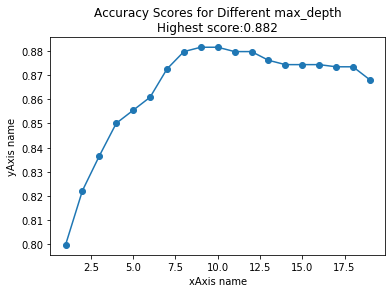

In [227]:
line=plt.plot(max_depth_rf,scores_rf,marker='o')
plt.title('Accuracy Scores for Different max_depth'+'\n' 'Highest score:' +str(round(max(scores_rf),3)))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

In [332]:
model = RandomForestClassifier(max_depth=9, n_estimators=1000, max_features=1,random_state=42)
model = model.fit(X_s, y_s)
score = model.score(X_test_enc, y_test_enc)

print(score)

0.8824057450628366


In [ ]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

#run algorithm multiple times to get desired accuracy
desired_accu = 0
while desired_accu < 0.88:

    
    #oversample training data to avoid skewness
    oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
    X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)
    #X_test = X_test.to_numpy()

    model = RandomForestClassifier(max_depth=9,n_estimators=1000).fit(X_s, y_s)

    model = model.fit(X_s, y_s)
    # evaluate the model
    scores = evaluate_model(X_test_enc, y_test_enc, model)
    desired_accu = np.mean(scores)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
